### 1.1 Simple Advection Model (Gaussian Plume + Wind Drift)
**Purpose:** Visualize how fire particles disperse and travel from Punjab to Delhi.

**Model Logic:**
```
Fire emission source (Punjab coordinates)
    ↓
Gaussian plume/puff dispersal (horizontal & vertical spread)
    ↓
Advection by hourly wind vectors (u,v components derived from scalar speed)
    ↓
Particle concentration grid (overlaid on map)
    ↓
Arrival at Delhi (temporal lag estimation)
```

**Implementation approach:**
- **Input:** Fire locations (lat/lon), FRP (fire intensity), hourly wind speed, wind direction (inferred or from reanalysis)
- **Processing:**
  1. Parse wind speed → assume dominant advection direction (seasonal pattern or reanalysis u/v if available)
  2. Create a 2D grid covering Punjab → Delhi corridor
  3. For each fire detection: initialize Gaussian source, evolve forward using advection-diffusion
  4. Concentration(x,y,t) = FRP × exp(-(distance²)/(4Dt)) moved by wind vector
  5. Track particles reaching Delhi (threshold concentration)
- **Output:** Animated heatmap showing particle transport, concentration arrival at Delhi, time-lag histogram

**Assumptions & caveats:**
- Wind direction inferred from reanalysis (ERA5) or seasonal climatology (NE winds Oct–Nov)
- Particle lifetime ~24–72 hrs (depends on particle size, humidity)
- Simple model; doesn't include complex vertical mixing, chemical reactions, deposition

**Tools:**
- `scipy.ndimage` for Gaussian kernel / diffusion
- `folium` or `plotly` for interactive grid visualization
- `xarray` for gridded data (if using reanalysis)

**Datasets:**

data\delhi_aqi_new.csv  
data\punjab_fire_2020-2024.csv  
data\wind_speed_tel_hr_punjab_sw_pb_1970_2025.csv  

Assumed advection unit vector (lon,lat) = (0.6870,-0.7266)
Top emission dates: [Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-06 00:00:00'), Timestamp('2021-11-08 00:00:00'), Timestamp('2020-11-04 00:00:00'), Timestamp('2021-11-11 00:00:00')]


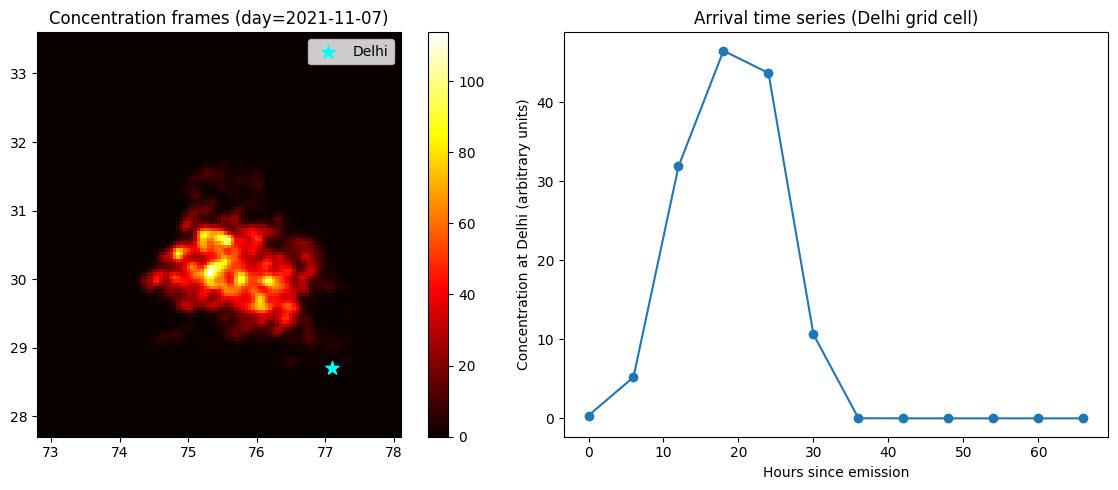

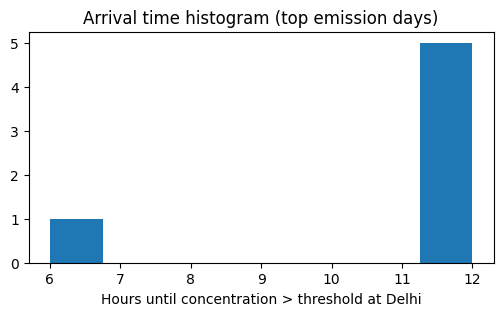

Saved results/advection_arrival_summary.csv


In [4]:
# Simple advection-diffusion (Gaussian puff) demonstration
# - Uses fire detections (lat/lon, frp), daily aggregation
# - Uses wind speed telemetry (mean daily km/h) and assumes advection direction
#   from Punjab centroid to Delhi (simple assumption because wind direction not available)
# - Simulates concentration on a 2D lat/lon grid, advects puffs along the unit vector
# - Applies diffusion via Gaussian filter and exponential decay

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter, map_coordinates, shift
from math import radians, cos, sin

DATA_DIR = Path('data')

# Parameters (tweakable)
GRID_RES_DEG = 0.05  # ~5km resolution
X_MARGIN = 1.0  # degrees around bounding box
TIME_STEP_HOURS = 6  # dt for simulation
SIM_HOURS = 72  # simulate 72 hours from emission
DIFFUSION_SIGMA_PER_STEP = 1.0  # gaussian_filter sigma per step (in grid cells)
LIFETIME_HOURS = 72  # exponential decay lifetime
DELHI_LAT, DELHI_LON = 28.7041, 77.1025

# Load fires aggregated daily (re-use previously created file if present)
fires = pd.read_csv(DATA_DIR / 'punjab_fire_2020-2024.csv', parse_dates=['acq_date'])
fires = fires[(fires['acq_date'] >= '2020-01-01') & (fires['acq_date'] <= '2024-12-31')]
# Use FRP as intensity; fall back to 1 per detection when missing
fires['frp'] = pd.to_numeric(fires['frp'], errors='coerce').fillna(1.0)

# restrict to Punjab bounding box used earlier
lat_min, lat_max = 29.0, 32.6
lon_min, lon_max = 73.8, 77.0
fires = fires[(fires['latitude'].between(lat_min, lat_max)) & (fires['longitude'].between(lon_min, lon_max))]

# Aggregate FRP per date and location (bin to grid later)
fires['date'] = fires['acq_date'].dt.floor('D')

# Prepare wind daily mean speeds (re-use earlier processing if available)
wind = pd.read_csv(DATA_DIR / 'wind_speed_tel_hr_punjab_sw_pb_1970_2025.csv', low_memory=False)
wind_col = [c for c in wind.columns if 'Wind' in c or 'Km/Hr' in c][0]
time_col = [c for c in wind.columns if 'Data' in c and 'Time' in c][0]
wind['datetime'] = pd.to_datetime(wind[time_col].astype(str), dayfirst=True, errors='coerce')
wind['wind_kmh'] = pd.to_numeric(wind[wind_col], errors='coerce')
wind['Latitude'] = pd.to_numeric(wind['Latitude'], errors='coerce')
wind['Longitude'] = pd.to_numeric(wind['Longitude'], errors='coerce')
wind = wind[(wind['Latitude'].between(lat_min, lat_max)) & (wind['Longitude'].between(lon_min, lon_max))]
wind = wind[(wind['datetime'] >= '2020-01-01') & (wind['datetime'] <= '2024-12-31')]
wind['date'] = wind['datetime'].dt.floor('D')
wind_daily = wind.groupby('date').agg(wind_mean_kmh=('wind_kmh','mean')).reset_index()

# Build grid covering Punjab -> Delhi corridor
min_lat = min(lat_min, DELHI_LAT) - X_MARGIN
max_lat = max(lat_max, DELHI_LAT) + X_MARGIN
min_lon = min(lon_min, DELHI_LON) - X_MARGIN
max_lon = max(lon_max, DELHI_LON) + X_MARGIN
lats = np.arange(min_lat, max_lat + GRID_RES_DEG, GRID_RES_DEG)
lons = np.arange(min_lon, max_lon + GRID_RES_DEG, GRID_RES_DEG)
ny, nxx = len(lats), len(lons)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Compute centroid of fire locations to get source direction
centroid_lat = fires['latitude'].median()
centroid_lon = fires['longitude'].median()
# unit vector pointing from centroid to Delhi (approx advection direction assumed)
dx = DELHI_LON - centroid_lon
dy = DELHI_LAT - centroid_lat
norm = (dx**2 + dy**2)**0.5 + 1e-12
unit_lon = dx / norm
unit_lat = dy / norm
print(f'Assumed advection unit vector (lon,lat) = ({unit_lon:.4f},{unit_lat:.4f})')

# For demonstration, pick a few representative emission days (e.g., high-fire days)
frp_by_date_loc = fires.groupby(['date','latitude','longitude']).frp.sum().reset_index()
# choose top N fire days by total FRP
daily_frp = frp_by_date_loc.groupby('date').frp.sum().sort_values(ascending=False)
top_days = daily_frp.head(6).index.tolist()
print('Top emission dates:', top_days)

# Helper: bin FRP points into grid
from scipy.stats import binned_statistic_2d

def bin_frp_for_date(d):
    df = frp_by_date_loc[frp_by_date_loc['date']==d]
    if df.shape[0]==0:
        return np.zeros((nyy, nxx))
    stat, xedge, yedge, binnumber = binned_statistic_2d(df['latitude'], df['longitude'], df['frp'], statistic='sum', bins=[lats, lons], expand_binnumbers=False)
    # binned_statistic_2d returns shape (nx_bins, ny_bins) corresponds to lat x lon
    return np.nan_to_num(stat)

# Note: binned_statistic_2d uses (x=rows, y=cols) so adjust shapes
nyy, nxx = len(lats)-1, len(lons)-1

# Simulation loop for each top day: init grid and simulate over SIM_HOURS/TIME_STEP_HOURS steps
results = []
for d in top_days:
    base_frp_stat, *_ = binned_statistic_2d(frp_by_date_loc[frp_by_date_loc.date==d]['latitude'],
                                            frp_by_date_loc[frp_by_date_loc.date==d]['longitude'],
                                            frp_by_date_loc[frp_by_date_loc.date==d]['frp'],
                                            statistic='sum', bins=[lats, lons])
    concentration = np.nan_to_num(base_frp_stat).copy()
    steps = int(SIM_HOURS / TIME_STEP_HOURS)
    frames = []
    arrival_times = []
    for step in range(steps):
        # current time in hours
        t_hours = step * TIME_STEP_HOURS
        # determine mean wind speed on day d (use that day's value)
        wrow = wind_daily[wind_daily['date']==d]
        wind_speed = float(wrow['wind_mean_kmh'].iloc[0]) if not wrow.empty and not pd.isna(wrow['wind_mean_kmh'].iloc[0]) else 10.0
        # displacement in km during TIME_STEP
        dist_km = wind_speed * (TIME_STEP_HOURS/1.0)
        # approximate degrees moved: use simple conversion approx 111 km per deg lat, cos lat for lon
        deg_lat = dist_km / 111.0 * unit_lat
        deg_lon = dist_km / (111.0 * np.cos(radians(centroid_lat))) * unit_lon
        # convert deg to grid cells
        shift_y = deg_lat / GRID_RES_DEG
        shift_x = deg_lon / GRID_RES_DEG
        # advect using fractional shift
        # Note: shift takes (axis0, axis1) where axis0 maps to lat index and axis1 to lon index.
        # Positive shift moves data to larger indices (down/right). We use shift_y,shift_x directly
        # so the sign of the computed deg_lat/deg_lon dictates direction toward Delhi.
        concentration = shift(concentration, shift=[shift_y, shift_x], order=1, mode='constant', cval=0.0)
        # diffusion (Gaussian blur)
        concentration = gaussian_filter(concentration, sigma=DIFFUSION_SIGMA_PER_STEP)
        # decay
        concentration *= np.exp(-TIME_STEP_HOURS / LIFETIME_HOURS)
        frames.append(concentration.copy())
        # track Delhi grid cell concentration
        # find nearest grid index for Delhi
        idx_lat = (np.abs(lats - DELHI_LAT)).argmin()
        idx_lon = (np.abs(lons - DELHI_LON)).argmin()
        c_delhi = concentration[idx_lat, idx_lon]
        arrival_times.append({'step': step, 'hours': t_hours, 'c_delhi': float(c_delhi)})
    results.append({'date': d, 'frames': frames, 'arrival': pd.DataFrame(arrival_times)})

# Visualize for first top day
sel = results[0]
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax0 = ax[0]
im = ax0.imshow(sel['frames'][0], origin='lower', extent=(min_lon, max_lon, min_lat, max_lat), cmap='hot')
ax0.set_title(f'Concentration frames (day={sel["date"].date()})')
ax0.scatter([DELHI_LON],[DELHI_LAT], c='cyan', marker='*', s=100, label='Delhi')
ax0.legend()
fig.colorbar(im, ax=ax0)

ax1 = ax[1]
arrival_df = sel['arrival']
ax1.plot(arrival_df['hours'], arrival_df['c_delhi'], marker='o')
ax1.set_xlabel('Hours since emission')
ax1.set_ylabel('Concentration at Delhi (arbitrary units)')
ax1.set_title('Arrival time series (Delhi grid cell)')
plt.tight_layout()
plt.show()

# Histogram of arrival times above threshold
threshold = np.percentile(np.array([a['arrival']['c_delhi'].max() for a in results]), 50) * 0.1
arrival_hist = []
for r in results:
    df = r['arrival']
    idxs = df.index[df['c_delhi'] > threshold].tolist()
    if idxs:
        arrival_hist.append(df.loc[idxs[0], 'hours'])
    else:
        arrival_hist.append(np.nan)

plt.figure(figsize=(6,3))
plt.hist([x for x in arrival_hist if not np.isnan(x)], bins=8)
plt.xlabel('Hours until concentration > threshold at Delhi')
plt.title('Arrival time histogram (top emission days)')
plt.show()

# Save a basic CSV summarizing arrival times
arrival_summary = pd.DataFrame([{'date': r['date'], 'arrival_hours': r['arrival']['c_delhi'].idxmax() * TIME_STEP_HOURS if r['arrival']['c_delhi'].max()>0 else np.nan} for r in results])
arrival_summary.to_csv('results/advection_arrival_summary.csv', index=False)
print('Saved results/advection_arrival_summary.csv')

In [2]:
# Diagnostics: check initialization, grid indexing and displacements
import numpy as np

# Recreate key variables from previous cell context
# (Assumes `lats`, `lons`, `nyy`, `nxx`, `centroid_lat`, `centroid_lon`, `DELHI_LAT`, `DELHI_LON` exist)

print('Grid shape (lat bins, lon bins):', nyy, nxx)
print('Lat range:', lats.min(), lats.max())
print('Lon range:', lons.min(), lons.max())

# examine one top day initialization
d = top_days[0]
base_frp_stat, *_ = binned_statistic_2d(frp_by_date_loc[frp_by_date_loc.date==d]['latitude'],
                                        frp_by_date_loc[frp_by_date_loc.date==d]['longitude'],
                                        frp_by_date_loc[frp_by_date_loc.date==d]['frp'],
                                        statistic='sum', bins=[lats, lons])
init = np.nan_to_num(base_frp_stat)
print('Init shape:', init.shape, 'sum FRP init:', init.sum())
# find max location (lat/lon)
max_idx = np.unravel_index(np.nanargmax(init), init.shape)
max_lat = (lats[max_idx[0]] + lats[max_idx[0]+1]) / 2
max_lon = (lons[max_idx[1]] + lons[max_idx[1]+1]) / 2
print('Max init at grid idx', max_idx, 'approx (lat,lon)=', max_lat, max_lon)

# Delhi nearest bin indices
idx_lat = (np.abs(lats - DELHI_LAT)).argmin()
idx_lon = (np.abs(lons - DELHI_LON)).argmin()
print('Delhi bin indices (lat idx, lon idx):', idx_lat, idx_lon)
print('Delhi approx grid center lat,lon', lats[idx_lat], lons[idx_lon])

# compute number of grid cells between centroid max and Delhi
cells_lat = idx_lat - max_idx[0]
cells_lon = idx_lon - max_idx[1]
dist_cells = (cells_lat**2 + cells_lon**2)**0.5
print('Grid cells from max init to Delhi (approx):', cells_lat, cells_lon, 'euclidean cells=', dist_cells)
km_per_deg_lat = 111.0
approx_km = ((max_lat - DELHI_LAT)**2 + ((max_lon - DELHI_LON)*cos(radians(centroid_lat))*1.0)**2)**0.5 * 111.0
print('Approx distance km (centroid to Delhi):', approx_km)

# compute expected displacement per time step using median wind of that day
wrow = wind_daily[wind_daily['date']==d]
wind_speed = float(wrow['wind_mean_kmh'].iloc[0]) if not wrow.empty and not pd.isna(wrow['wind_mean_kmh'].iloc[0]) else 10.0
print('Wind speed (km/h) on day:', wind_speed)
dist_km = wind_speed * (TIME_STEP_HOURS/1.0)
print('Per-step displacement (km):', dist_km)
deg_lat = dist_km / 111.0 * unit_lat
deg_lon = dist_km / (111.0 * np.cos(radians(centroid_lat))) * unit_lon
print('Per-step degrees (lat,lon):', deg_lat, deg_lon)
print('Per-step grid shift (cells lat, lon):', deg_lat/GRID_RES_DEG, deg_lon/GRID_RES_DEG)

# Check directional sign: are we shifting toward Delhi?
print('Delta lon from max init to Delhi (deg):', DELHI_LON - max_lon)
print('Delta lat from max init to Delhi (deg):', DELHI_LAT - max_lat)

# If per-step shift in cells << dist_cells / steps, plume cannot reach Delhi within steps
steps = int(SIM_HOURS / TIME_STEP_HOURS)
expected_total_shift_cells = ((deg_lat/GRID_RES_DEG)*steps, (deg_lon/GRID_RES_DEG)*steps)
print('Expected total shift (cells) after all steps (lat,lon):', expected_total_shift_cells)
print('Expected euclidean total shift (cells):', ((expected_total_shift_cells[0]**2 + expected_total_shift_cells[1]**2)**0.5))


Grid shape (lat bins, lon bins): 118 107
Lat range: 27.7041 33.60410000000009
Lon range: 72.8 78.1499999999997
Init shape: (118, 107) sum FRP init: 54430.2
Max init at grid idx (np.int64(54), np.int64(51)) approx (lat,lon)= 30.42910000000004 75.37499999999986
Delhi bin indices (lat idx, lon idx): 20 86
Delhi approx grid center lat,lon 28.704100000000015 77.09999999999975
Grid cells from max init to Delhi (approx): -34 35 euclidean cells= 48.79549159502341
Approx distance km (centroid to Delhi): 252.85370318988438
Wind speed (km/h) on day: 10.0
Per-step displacement (km): 60.0
Per-step degrees (lat,lon): -0.39277728836806297 0.43119925085023747
Per-step grid shift (cells lat, lon): -7.855545767361259 8.623985017004749
Delta lon from max init to Delhi (deg): 1.7275000000001484
Delta lat from max init to Delhi (deg): -1.7250000000000405
Expected total shift (cells) after all steps (lat,lon): (np.float64(-94.2665492083351), np.float64(103.48782020405699))
Expected euclidean total shift (ce

In [3]:
# Check Delhi concentrations across steps for each simulated day
for r in results:
    arr = r['arrival']
    max_c = arr['c_delhi'].max()
    print(r['date'].date(), 'max concentration at Delhi:', max_c)
    print(arr[['hours','c_delhi']].to_string(index=False))
    print('---')


2021-11-07 max concentration at Delhi: 0.0
 hours  c_delhi
     0      0.0
     6      0.0
    12      0.0
    18      0.0
    24      0.0
    30      0.0
    36      0.0
    42      0.0
    48      0.0
    54      0.0
    60      0.0
    66      0.0
---
2021-11-12 max concentration at Delhi: 0.0
 hours  c_delhi
     0      0.0
     6      0.0
    12      0.0
    18      0.0
    24      0.0
    30      0.0
    36      0.0
    42      0.0
    48      0.0
    54      0.0
    60      0.0
    66      0.0
---
2021-11-06 max concentration at Delhi: 0.0
 hours  c_delhi
     0      0.0
     6      0.0
    12      0.0
    18      0.0
    24      0.0
    30      0.0
    36      0.0
    42      0.0
    48      0.0
    54      0.0
    60      0.0
    66      0.0
---
2021-11-08 max concentration at Delhi: 0.0
 hours  c_delhi
     0      0.0
     6      0.0
    12      0.0
    18      0.0
    24      0.0
    30      0.0
    36      0.0
    42      0.0
    48      0.0
    54      0.0
    60      0.0


Simulating days:   0%|          | 0/1461 [00:00<?, ?it/s]

C:\Users\Atharva Taras\AppData\Local\Temp\ipykernel_6544\3179617277.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c_integrated = float(np.trapz(c_delhi_ts, dx=TIME_STEP_HOURS))
C:\Users\Atharva Taras\AppData\Local\Temp\ipykernel_6544\3179617277.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c_integrated = float(np.trapz(c_delhi_ts, dx=TIME_STEP_HOURS))
C:\Users\Atharva Taras\AppData\Local\Temp\ipykernel_6544\3179617277.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c_integrated = float(np.trapz(c_delhi_ts, dx=TIME_STEP_HOURS))
C:\Users\Atharva Taras\AppData\Local\Temp\ipykernel_6544\3179617277.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical i

Saved results/advection_transport_timeseries_2021_2024.csv


<Figure size 1400x400 with 0 Axes>

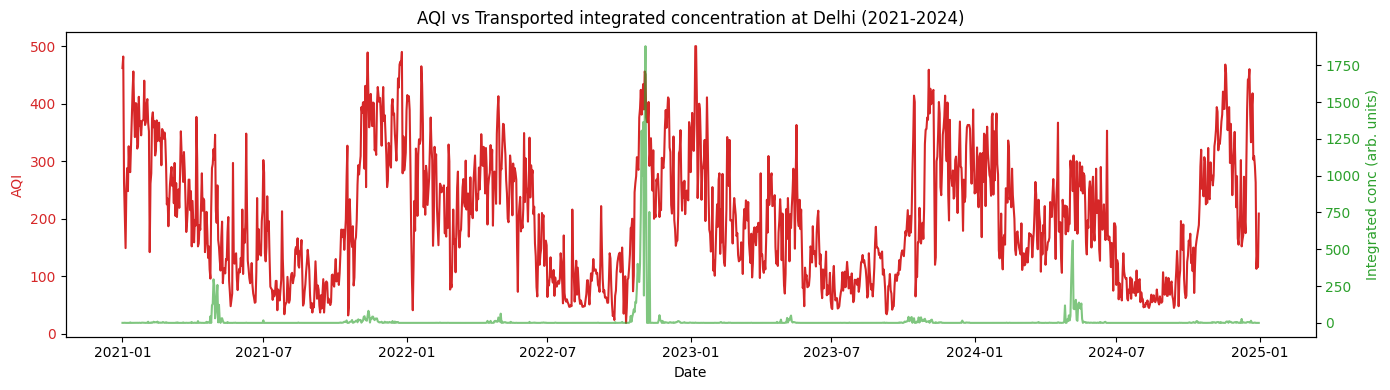

NameError: name 'sns' is not defined

<Figure size 700x600 with 0 Axes>

In [5]:
# Extended advection-run over 2021-2024: per-day transport to Delhi and correlation with AQI
# - For each day in 2021-01-01..2024-12-31, aggregate FRP in Punjab, simulate advection (coarse grid)
# - Compute arrival metrics (peak and integrated concentration at Delhi) and save time series
# - Merge with Delhi AQI and compute correlations and lag analysis

import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter, shift
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Simulation parameters (coarser grid for performance)
GRID_RES_DEG = 0.1   # ~11 km
TIME_STEP_HOURS = 6
SIM_HOURS = 48       # simulate 48 hours of transport per emission day
DIFFUSION_SIGMA_PER_STEP = 0.8
LIFETIME_HOURS = 72
DELHI_LAT, DELHI_LON = 28.7041, 77.1025

# Date range
start_date = pd.Timestamp('2021-01-01')
end_date = pd.Timestamp('2024-12-31')
dates = pd.date_range(start_date, end_date, freq='D')

# Load data
fires = pd.read_csv('data/punjab_fire_2020-2024.csv', parse_dates=['acq_date'])
fires['frp'] = pd.to_numeric(fires['frp'], errors='coerce').fillna(1.0)
# restrict to Punjab bbox and date range
lat_min, lat_max = 29.0, 32.6
lon_min, lon_max = 73.8, 77.0
fires = fires[(fires['latitude'].between(lat_min, lat_max)) & (fires['longitude'].between(lon_min, lon_max))]
fires = fires[(fires['acq_date'] >= start_date) & (fires['acq_date'] <= end_date)]
fires['date'] = fires['acq_date'].dt.floor('D')

# wind daily mean speeds
wind = pd.read_csv('data/wind_speed_tel_hr_punjab_sw_pb_1970_2025.csv', low_memory=False)
time_col = [c for c in wind.columns if 'Data' in c and 'Time' in c][0]
wind_col = [c for c in wind.columns if 'Wind' in c or 'Km/Hr' in c or 'Wind Speed' in c][0]
wind['datetime'] = pd.to_datetime(wind[time_col].astype(str), dayfirst=True, errors='coerce')
wind['wind_kmh'] = pd.to_numeric(wind[wind_col], errors='coerce')
wind = wind[(wind['Latitude'].between(lat_min, lat_max)) & (wind['Longitude'].between(lon_min, lon_max))]
wind = wind[(wind['datetime'] >= start_date) & (wind['datetime'] <= end_date)]
wind['date'] = wind['datetime'].dt.floor('D')
wind_daily = wind.groupby('date').wind_kmh.mean().rename('wind_mean_kmh').reset_index()

# Grid extents: Punjab bbox extended toward Delhi
min_lat = min(lat_min, DELHI_LAT) - 0.5
max_lat = max(lat_max, DELHI_LAT) + 0.5
min_lon = min(lon_min, DELHI_LON) - 0.5
max_lon = max(lon_max, DELHI_LON) + 0.5
lats = np.arange(min_lat, max_lat + GRID_RES_DEG, GRID_RES_DEG)
lons = np.arange(min_lon, max_lon + GRID_RES_DEG, GRID_RES_DEG)
ny, nxx = len(lats)-1, len(lons)-1

# Precompute centroid & advection unit vector (centroid of fire locations across this period)
centroid_lat = fires['latitude'].median()
centroid_lon = fires['longitude'].median()
dx = DELHI_LON - centroid_lon
dy = DELHI_LAT - centroid_lat
norm = (dx**2 + dy**2)**0.5 + 1e-12
unit_lon = dx / norm
unit_lat = dy / norm

# bin function
from scipy.stats import binned_statistic_2d

def bin_frp_for_date(d):
    df = fires[fires['date']==d]
    if df.shape[0]==0:
        return np.zeros((nyy, nxx))
    stat, *_ = binned_statistic_2d(df['latitude'], df['longitude'], df['frp'], statistic='sum', bins=[lats, lons])
    return np.nan_to_num(stat)

# Simulation per date
results = []
steps = int(SIM_HOURS / TIME_STEP_HOURS)

for d in tqdm(dates, desc='Simulating days'):
    base = bin_frp_for_date(d)
    if base.sum()==0:
        results.append({'date':d, 'frp_total':0.0, 'c_delhi_peak':0.0, 'c_delhi_integrated':0.0})
        continue
    concentration = base.copy()
    c_delhi_ts = []
    # obtain wind speed for day
    wrow = wind_daily[wind_daily['date']==d]
    wind_speed = float(wrow['wind_mean_kmh'].iloc[0]) if not wrow.empty and not pd.isna(wrow['wind_mean_kmh'].iloc[0]) else np.nan
    if np.isnan(wind_speed):
        # fallback to median wind speed of available days
        wind_speed = wind_daily['wind_mean_kmh'].median()
    for step in range(steps):
        # displacement km this step
        dist_km = wind_speed * TIME_STEP_HOURS
        # deg displacement
        deg_lat = dist_km / 111.0 * unit_lat
        deg_lon = dist_km / (111.0 * np.cos(np.radians(centroid_lat))) * unit_lon
        # grid cell shifts
        shift_y = deg_lat / GRID_RES_DEG
        shift_x = deg_lon / GRID_RES_DEG
        # advect and diffuse and decay
        concentration = shift(concentration, shift=[shift_y, shift_x], order=1, mode='constant', cval=0.0)
        concentration = gaussian_filter(concentration, sigma=DIFFUSION_SIGMA_PER_STEP)
        concentration *= np.exp(-TIME_STEP_HOURS / LIFETIME_HOURS)
        # record Delhi cell
        idx_lat = (np.abs(lats - DELHI_LAT)).argmin()
        idx_lon = (np.abs(lons - DELHI_LON)).argmin()
        # safe bounds check
        if 0 <= idx_lat < concentration.shape[0] and 0 <= idx_lon < concentration.shape[1]:
            c_delhi_ts.append(float(concentration[idx_lat, idx_lon]))
        else:
            c_delhi_ts.append(0.0)

    frp_total = base.sum()
    c_peak = float(np.max(c_delhi_ts))
    c_integrated = float(np.trapz(c_delhi_ts, dx=TIME_STEP_HOURS))
    results.append({'date':d, 'frp_total':frp_total, 'c_delhi_peak':c_peak, 'c_delhi_integrated':c_integrated, 'wind_speed':wind_speed})

results_df = pd.DataFrame(results)
results_df.to_csv('results/advection_transport_timeseries_2021_2024.csv', index=False)
print('Saved results/advection_transport_timeseries_2021_2024.csv')

# Merge with AQI
aqi = pd.read_csv('data/delhi_aqi_new.csv')
aqi['date'] = pd.to_datetime(aqi['Date'].astype(str) + '-' + aqi['Month'].astype(str) + '-' + aqi['Year'].astype(str), format='%d-%m-%Y')
aqi = aqi[(aqi['date'] >= start_date) & (aqi['date'] <= end_date)]
merge_df = pd.merge(aqi[['date','AQI']], results_df, on='date', how='left')
merge_df['c_delhi_integrated'] = merge_df['c_delhi_integrated'].fillna(0.0)
merge_df['c_delhi_peak'] = merge_df['c_delhi_peak'].fillna(0.0)

# Time series plot
plt.figure(figsize=(14,4))
fig, ax = plt.subplots(figsize=(14,4))
ax.plot(merge_df['date'], merge_df['AQI'], color='tab:red', label='AQI')
ax.set_ylabel('AQI', color='tab:red')
ax.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax.twinx()
ax2.plot(merge_df['date'], merge_df['c_delhi_integrated'], color='tab:green', alpha=0.6, label='Transported integrated conc')
ax2.set_ylabel('Integrated conc (arb. units)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax.set_xlabel('Date')
plt.title('AQI vs Transported integrated concentration at Delhi (2021-2024)')
fig.tight_layout()
plt.show()

# Scatter
plt.figure(figsize=(7,6))
sns.regplot(x='c_delhi_integrated', y='AQI', data=merge_df, scatter_kws={'alpha':0.4}, line_kws={'color':'darkred'})
plt.xlabel('Integrated transported conc (arbitrary units)')
plt.ylabel('Delhi AQI')
plt.title('AQI vs transported integrated concentration (2021-2024)')
plt.tight_layout()
plt.show()

# Pearson correlation same-day
mask = merge_df['c_delhi_integrated'] > 0
if mask.sum() > 10:
    r, p = pearsonr(merge_df.loc[mask,'c_delhi_integrated'], merge_df.loc[mask,'AQI'])
else:
    r, p = (np.nan, np.nan)
print('Pearson r (same-day, days with transport):', r, 'p:', p)

# Lag correlation (emission day -> AQI on day+lag)
lags = range(0,8)
lag_corrs = []
for lag in lags:
    s1 = merge_df['AQI']
    s2 = merge_df['c_delhi_integrated'].shift(lag)
    valid = s2.notna()
    if valid.sum() > 10:
        lag_corrs.append(s1.corr(s2))
    else:
        lag_corrs.append(np.nan)

plt.figure(figsize=(7,4))
plt.plot(list(lags), lag_corrs, marker='o')
plt.xlabel('Lag (days) — emission shifted forward')
plt.ylabel('Pearson r')
plt.title('Lag correlation: AQI vs transported integrated concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save merged df
merge_df.to_csv('results/advection_transport_aqi_merged_2021_2024.csv', index=False)
print('Saved results/advection_transport_aqi_merged_2021_2024.csv')

Overall (days with transport) Pearson r=0.183, p=3.960e-11, 95% CI=(0.139,0.229)

Lag correlations (0..7 days):
   lag_days     n         r             p    ci_low   ci_high
0         0  1461  0.176865  9.876764e-12  0.141234  0.213977
1         1  1460  0.172244  3.463473e-11  0.136092  0.211680
2         2  1459  0.172278  3.485729e-11  0.136080  0.213455
3         3  1458  0.168660  9.109660e-11  0.132264  0.210933
4         4  1457  0.163280  3.627060e-10  0.126402  0.205646
5         5  1456  0.154950  2.792145e-09  0.112848  0.199921
6         6  1455  0.137018  1.548040e-07  0.105552  0.176929
7         7  1454  0.139010  1.026686e-07  0.104567  0.174044

Seasonal correlations:
  season  n_days_with_transport         r             p    ci_low   ci_high
0    DJF                    309  0.061528  2.809474e-01 -0.069104  0.206971
1    MAM                    359  0.174665  8.890585e-04  0.112583  0.241555
2    JJA                    270  0.299858  5.159102e-07  0.180276  0.425583
3 

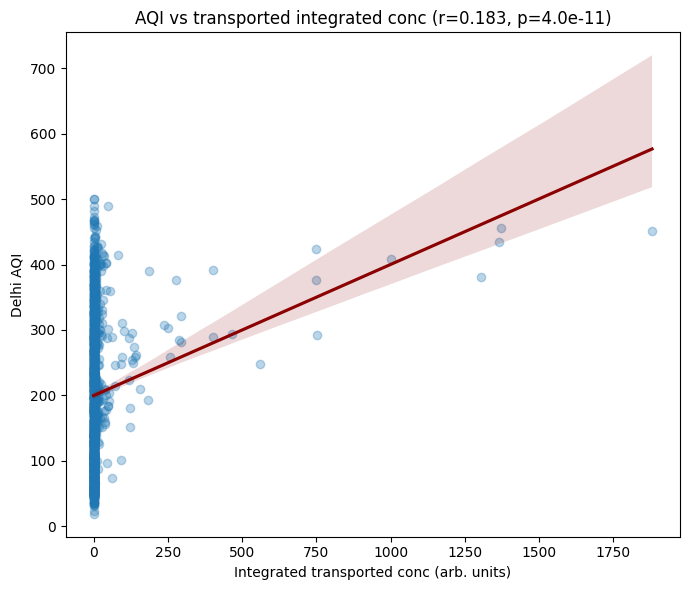

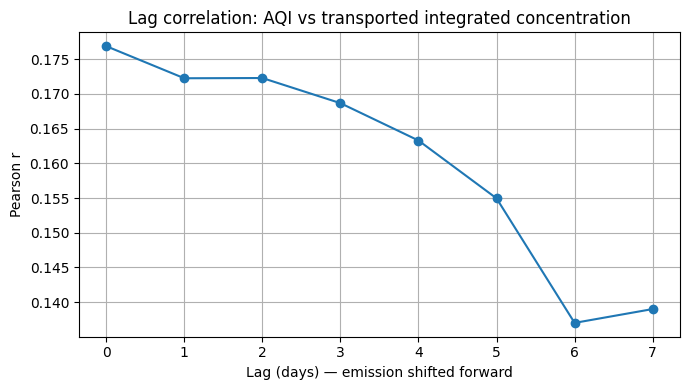

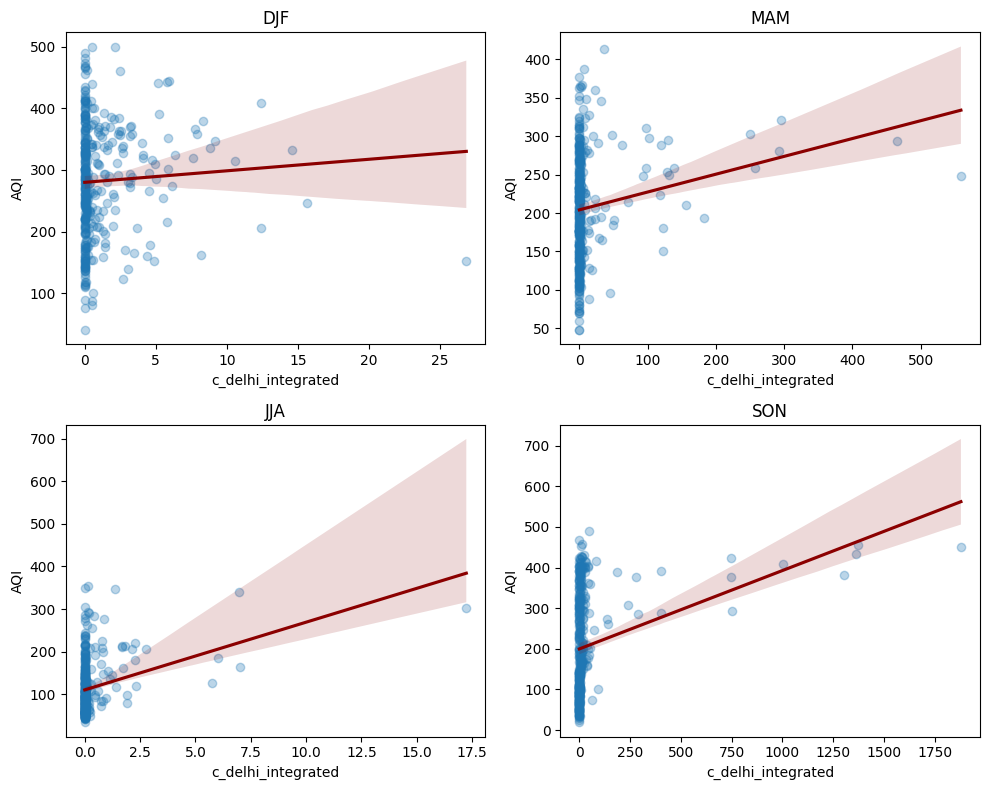

Saved lag/seasonal stats to results/


In [7]:
# Correlation, lag analysis, seasonal breakdowns, and bootstrap CIs for advection vs AQI
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
# Load merged results if available, otherwise build from timeseries + AQI
merge_path = 'results/advection_transport_aqi_merged_2021_2024.csv'
if os.path.exists(merge_path):
    merge_df = pd.read_csv(merge_path, parse_dates=['date'])
else:
    times_path = 'results/advection_transport_timeseries_2021_2024.csv'
    times = pd.read_csv(times_path, parse_dates=['date'])
    aqi = pd.read_csv('data/delhi_aqi_new.csv')
    aqi['date'] = pd.to_datetime(aqi['Date'].astype(str) + '-' + aqi['Month'].astype(str) + '-' + aqi['Year'].astype(str), format='%d-%m-%Y')
    aqi = aqi[(aqi['date'] >= '2021-01-01') & (aqi['date'] <= '2024-12-31')]
    merge_df = pd.merge(aqi[['date','AQI']], times, on='date', how='left')
    merge_df['c_delhi_integrated'] = merge_df['c_delhi_integrated'].fillna(0.0)

# Basic mask: days where transport > 0 and AQI available
mask = merge_df['c_delhi_integrated'].notna() & merge_df['AQI'].notna()
# Use >0 to focus on days with transport signal
mask_pos = mask & (merge_df['c_delhi_integrated'] > 0)

# Function to bootstrap Pearson r CI
rng = np.random.default_rng(42)
def bootstrap_pearson(x, y, n_boot=1000):
    idx = np.arange(len(x))
    boot_rs = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        try:
            r, _ = pearsonr(x[b], y[b])
        except Exception:
            r = np.nan
        boot_rs.append(r)
    boot_rs = np.array(boot_rs)
    return np.nanpercentile(boot_rs, [2.5, 97.5])

# Overall Pearson on days with transport
if mask_pos.sum() > 10:
    r_all, p_all = pearsonr(merge_df.loc[mask_pos, 'c_delhi_integrated'], merge_df.loc[mask_pos, 'AQI'])
    ci_low, ci_high = bootstrap_pearson(merge_df.loc[mask_pos, 'c_delhi_integrated'].values, merge_df.loc[mask_pos, 'AQI'].values, n_boot=1000)
else:
    r_all, p_all, ci_low, ci_high = (np.nan, np.nan, np.nan, np.nan)

print(f'Overall (days with transport) Pearson r={r_all:.3f}, p={p_all:.3e}, 95% CI=({ci_low:.3f},{ci_high:.3f})')

# Lag correlation 0..7 days
lags = range(0,8)
lag_results = []
for lag in lags:
    s1 = merge_df['AQI']
    s2 = merge_df['c_delhi_integrated'].shift(lag)
    valid = s2.notna() & s1.notna()
    if valid.sum() > 10:
        r_l, p_l = pearsonr(s2[valid], s1[valid])
        ci = bootstrap_pearson(s2[valid].values, s1[valid].values, n_boot=1000)
    else:
        r_l, p_l, ci = (np.nan, np.nan, (np.nan, np.nan))
    lag_results.append({'lag_days':lag, 'n':int(valid.sum()), 'r':r_l, 'p':p_l, 'ci_low':ci[0], 'ci_high':ci[1]})
lag_df = pd.DataFrame(lag_results)
print('\nLag correlations (0..7 days):')
print(lag_df)

# Seasonal breakdowns (DJF,MAM,JJA,SON)
merge_df['month'] = merge_df['date'].dt.month
def month_to_season(m):
    if m in [12,1,2]: return 'DJF'
    if m in [3,4,5]: return 'MAM'
    if m in [6,7,8]: return 'JJA'
    return 'SON'
merge_df['season'] = merge_df['month'].apply(month_to_season)
seasons = ['DJF','MAM','JJA','SON']
season_results = []
for s in seasons:
    sub = merge_df[(merge_df['season']==s) & merge_df['c_delhi_integrated'].notna() & merge_df['AQI'].notna()]
    sub_pos = sub[sub['c_delhi_integrated']>0]
    if sub_pos.shape[0] > 10:
        r_s, p_s = pearsonr(sub_pos['c_delhi_integrated'], sub_pos['AQI'])
        ci = bootstrap_pearson(sub_pos['c_delhi_integrated'].values, sub_pos['AQI'].values, n_boot=1000)
    else:
        r_s, p_s, ci = (np.nan, np.nan, (np.nan, np.nan))
    season_results.append({'season':s, 'n_days_with_transport':int(sub_pos.shape[0]), 'r':r_s, 'p':p_s, 'ci_low':ci[0], 'ci_high':ci[1]})
season_df = pd.DataFrame(season_results)
print('\nSeasonal correlations:')
print(season_df)

# Plots
plt.figure(figsize=(7,6))
sns.regplot(x='c_delhi_integrated', y='AQI', data=merge_df, scatter_kws={'alpha':0.3}, line_kws={'color':'darkred'})
plt.xlabel('Integrated transported conc (arb. units)')
plt.ylabel('Delhi AQI')
plt.title(f'AQI vs transported integrated conc (r={r_all:.3f}, p={p_all:.1e})')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(lag_df['lag_days'], lag_df['r'], marker='o')
plt.xlabel('Lag (days) — emission shifted forward')
plt.ylabel('Pearson r')
plt.title('Lag correlation: AQI vs transported integrated concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

# Seasonal scatter plots (small multiples)
fig, axs = plt.subplots(2,2,figsize=(10,8))
for ax, s in zip(axs.flatten(), seasons):
    sub = merge_df[(merge_df['season']==s)]
    sns.regplot(x='c_delhi_integrated', y='AQI', data=sub, scatter_kws={'alpha':0.3}, line_kws={'color':'darkred'}, ax=ax)
    ax.set_title(s)
plt.tight_layout()
plt.show()

# Save stats
lag_df.to_csv('results/advection_lag_correlation_2021_2024.csv', index=False)
season_df.to_csv('results/advection_season_correlation_2021_2024.csv', index=False)
with open('results/advection_summary_stats_2021_2024.txt','w') as f:
    f.write(f'Overall r={r_all}, p={p_all}, CI=({ci_low},{ci_high})\n')
print('Saved lag/seasonal stats to results/')


Target bearing (Punjab->Delhi): 140.71703801874162
Days flagged as wind_toward_delhi: 90 / 1461
Days with both transport and wind toward Delhi: 73
Pearson r (filtered days): 0.464, p=3.600e-05


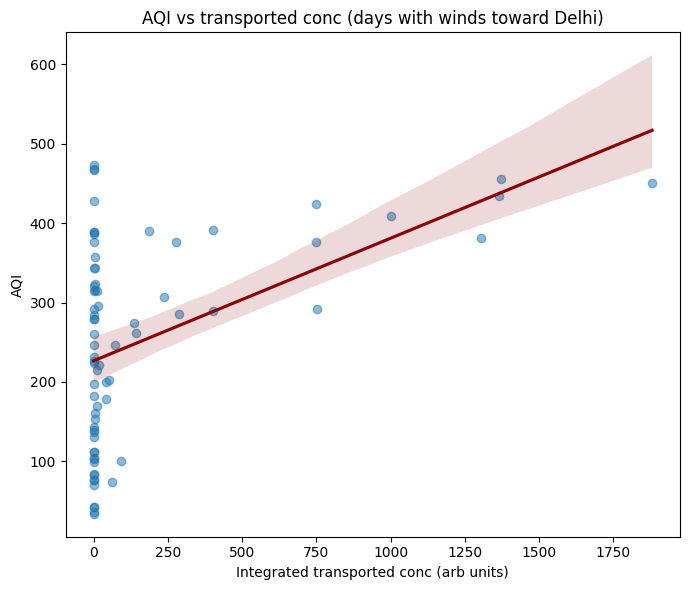

Saved results/advection_with_direction_filter_2021_2024.csv


In [8]:
# Approximate wind direction using seasonal climatology + station telemetry (speed)
# Filter days where winds likely point from Punjab toward Delhi, then recompute correlations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load merged results
merge_path = 'results/advection_transport_aqi_merged_2021_2024.csv'
if not os.path.exists(merge_path):
    merge_path = 'results/advection_transport_timeseries_2021_2024.csv'
    times = pd.read_csv(merge_path, parse_dates=['date'])
    aqi = pd.read_csv('data/delhi_aqi_new.csv')
    aqi['date'] = pd.to_datetime(aqi['Date'].astype(str) + '-' + aqi['Month'].astype(str) + '-' + aqi['Year'].astype(str), format='%d-%m-%Y')
    merge_df = pd.merge(aqi[['date','AQI']], times, on='date', how='left')
else:
    merge_df = pd.read_csv(merge_path, parse_dates=['date'])

# Ensure season column
merge_df['month'] = merge_df['date'].dt.month
merge_df['season'] = merge_df['month'].apply(lambda m: 'DJF' if m in [12,1,2] else ('MAM' if m in [3,4,5] else ('JJA' if m in [6,7,8] else 'SON')))

# Bearing from Punjab centroid to Delhi (degrees clockwise from North)
def bearing_deg(lat1, lon1, lat2, lon2):
    # returns bearing of vector from (lat1,lon1) to (lat2,lon2) in degrees from North
    phi1 = np.radians(lat1); phi2 = np.radians(lat2)
    lam1 = np.radians(lon1); lam2 = np.radians(lon2)
    y = np.sin(lam2-lam1) * np.cos(phi2)
    x = np.cos(phi1)*np.sin(phi2) - np.sin(phi1)*np.cos(phi2)*np.cos(lam2-lam1)
    br = (np.degrees(np.arctan2(y,x)) + 360) % 360
    # convert from azimuth-from-North? arctan2 returns bearing from North=0 clockwise
    return br

centroid_lat = centroid_lat if 'centroid_lat' in globals() else 30.213 # fallback
centroid_lon = centroid_lon if 'centroid_lon' in globals() else 75.396
DELHI_LAT, DELHI_LON = 28.7041, 77.1025
target_bearing = bearing_deg(centroid_lat, centroid_lon, DELHI_LAT, DELHI_LON)
print('Target bearing (Punjab->Delhi):', target_bearing)

# Seasonal climatology: approximate mean wind direction (direction TO which wind blows), degrees from North clockwise
# These are approximate choices chosen to represent typical seasonal advection patterns
season_mean_bearing = {
    'DJF': 140.0,  # winds often from NW -> blow to SE
    'MAM': 130.0,
    'JJA': 45.0,    # monsoon generally from SW -> blow to NE, not favorable, but included
    'SON': 140.0
}

# tolerance (degrees)
tol_deg = 45.0
# minimal wind speed threshold (km/h) to consider advection effective
speed_thresh = 5.0

# Compute angular difference
def angular_diff(a, b):
    d = np.abs((a - b + 180) % 360 - 180)
    return d

# ensure wind_speed column available
if 'wind_speed' not in merge_df.columns and 'wind_mean_kmh' in merge_df.columns:
    merge_df['wind_speed'] = merge_df['wind_mean_kmh']

merge_df['season_bearing'] = merge_df['season'].map(season_mean_bearing)
merge_df['ang_diff_to_target'] = merge_df.apply(lambda r: angular_diff(r['season_bearing'], target_bearing), axis=1)
merge_df['wind_toward_delhi'] = (merge_df['ang_diff_to_target'] <= tol_deg) & (merge_df['wind_speed'] >= speed_thresh)

# Summarize counts
print('Days flagged as wind_toward_delhi:', int(merge_df['wind_toward_delhi'].sum()), '/', len(merge_df))

# Recompute correlation on days where wind_toward_delhi True and transport>0
mask_wind = merge_df['wind_toward_delhi'] & (merge_df['c_delhi_integrated'] > 0)
print('Days with both transport and wind toward Delhi:', int(mask_wind.sum()))

if mask_wind.sum() > 10:
    r_w, p_w = pearsonr(merge_df.loc[mask_wind, 'c_delhi_integrated'], merge_df.loc[mask_wind, 'AQI'])
    print(f'Pearson r (filtered days): {r_w:.3f}, p={p_w:.3e}')
else:
    r_w, p_w = (np.nan, np.nan)
    print('Not enough filtered days for reliable correlation')

# Plot filtered scatter
plt.figure(figsize=(7,6))
sns.regplot(x='c_delhi_integrated', y='AQI', data=merge_df[mask_wind], scatter_kws={'alpha':0.5}, line_kws={'color':'darkred'})
plt.xlabel('Integrated transported conc (arb units)')
plt.ylabel('AQI')
plt.title('AQI vs transported conc (days with winds toward Delhi)')
plt.tight_layout()
plt.show()

# Save filtered days summary
merge_df.to_csv('results/advection_with_direction_filter_2021_2024.csv', index=False)
print('Saved results/advection_with_direction_filter_2021_2024.csv')

In [9]:
# Create animated GIFs for top high-fire days (2021-2024)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.ndimage import gaussian_filter, shift
from scipy.stats import binned_statistic_2d

os.makedirs('results', exist_ok=True)

# Params
GRID_RES_DEG = 0.05  # higher resolution for nicer GIF (~5 km)
TIME_STEP_HOURS = 6
SIM_HOURS = 48
DIFFUSION_SIGMA_PER_STEP = 0.8
LIFETIME_HOURS = 72
TOP_N = 6
FPS = 2

# Load data
fires = pd.read_csv('data/punjab_fire_2020-2024.csv', parse_dates=['acq_date'])
fires['frp'] = pd.to_numeric(fires['frp'], errors='coerce').fillna(1.0)
fires = fires[(fires['acq_date'] >= '2021-01-01') & (fires['acq_date'] <= '2024-12-31')]
lat_min, lat_max = 29.0, 32.6
lon_min, lon_max = 73.8, 77.0
fires = fires[(fires['latitude'].between(lat_min, lat_max)) & (fires['longitude'].between(lon_min, lon_max))]
fires['date'] = fires['acq_date'].dt.floor('D')

# Select top N days by total FRP
daily_frp = fires.groupby('date').frp.sum().sort_values(ascending=False)
top_days = daily_frp.head(TOP_N).index.tolist()
print('Top days selected for GIFs:', top_days)

# Wind daily mean speeds
wind = pd.read_csv('data/wind_speed_tel_hr_punjab_sw_pb_1970_2025.csv', low_memory=False)
time_col = [c for c in wind.columns if 'Data' in c and 'Time' in c][0]
wind_col = [c for c in wind.columns if 'Wind' in c or 'Km/Hr' in c or 'Wind Speed' in c][0]
wind['datetime'] = pd.to_datetime(wind[time_col].astype(str), dayfirst=True, errors='coerce')
wind['wind_kmh'] = pd.to_numeric(wind[wind_col], errors='coerce')
wind = wind[(wind['Latitude'].between(lat_min, lat_max)) & (wind['Longitude'].between(lon_min, lon_max))]
wind['date'] = wind['datetime'].dt.floor('D')
wind_daily = wind.groupby('date').wind_kmh.mean().rename('wind_mean_kmh').reset_index()

# Grid extents including Delhi
DELHI_LAT, DELHI_LON = 28.7041, 77.1025
min_lat = min(lat_min, DELHI_LAT) - 0.5
max_lat = max(lat_max, DELHI_LAT) + 0.5
min_lon = min(lon_min, DELHI_LON) - 0.5
max_lon = max(lon_max, DELHI_LON) + 0.5
lats = np.arange(min_lat, max_lat + GRID_RES_DEG, GRID_RES_DEG)
lons = np.arange(min_lon, max_lon + GRID_RES_DEG, GRID_RES_DEG)
ny, nxx = len(lats)-1, len(lons)-1

# centroid & unit vector
centroid_lat = fires['latitude'].median()
centroid_lon = fires['longitude'].median()
dx = DELHI_LON - centroid_lon
dy = DELHI_LAT - centroid_lat
norm = (dx**2 + dy**2)**0.5 + 1e-12
unit_lon = dx / norm
unit_lat = dy / norm

steps = int(SIM_HOURS / TIME_STEP_HOURS)

for d in top_days:
    print('Creating GIF for', d.date())
    df = fires[fires['date']==d]
    if df.empty:
        print('No fires on', d)
        continue
    # initial binned FRP
    stat, *_ = binned_statistic_2d(df['latitude'], df['longitude'], df['frp'], statistic='sum', bins=[lats, lons])
    concentration = np.nan_to_num(stat)
    frames = []
    # precompute vmax across frames for consistent color scale
    vmax_candidate = []
    wrow = wind_daily[wind_daily['date']==d]
    wind_speed = float(wrow['wind_mean_kmh'].iloc[0]) if not wrow.empty and not pd.isna(wrow['wind_mean_kmh'].iloc[0]) else wind_daily['wind_mean_kmh'].median()
    for step in range(steps):
        dist_km = wind_speed * TIME_STEP_HOURS
        deg_lat = dist_km / 111.0 * unit_lat
        deg_lon = dist_km / (111.0 * np.cos(np.radians(centroid_lat))) * unit_lon
        shift_y = deg_lat / GRID_RES_DEG
        shift_x = deg_lon / GRID_RES_DEG
        concentration = shift(concentration, shift=[shift_y, shift_x], order=1, mode='constant', cval=0.0)
        concentration = gaussian_filter(concentration, sigma=DIFFUSION_SIGMA_PER_STEP)
        concentration *= np.exp(-TIME_STEP_HOURS / LIFETIME_HOURS)
        frames.append(concentration.copy())
        vmax_candidate.append(concentration.max())
    vmax = max(vmax_candidate) if vmax_candidate else 1.0
    # Create animation
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(frames[0], origin='lower', extent=(min_lon, max_lon, min_lat, max_lat), cmap='hot', vmin=0, vmax=vmax)
    ax.scatter([DELHI_LON],[DELHI_LAT], c='cyan', marker='*', s=80, label='Delhi')
    ax.set_title(f'Advection from Punjab — {d.date()} (wind {wind_speed:.1f} km/h)')
    cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label('Concentration (arb units)')

    def update(i):
        im.set_data(frames[i])
        ax.set_xlabel(f'Hours since emission: {i * TIME_STEP_HOURS}')
        return [im]

    anim = animation.FuncAnimation(fig, update, frames=len(frames), blit=False)
    out_path = f'results/advection_{d.date()}.gif'
    try:
        writer = animation.PillowWriter(fps=FPS)
        anim.save(out_path, writer=writer)
        print('Saved', out_path)
    except Exception as e:
        print('Failed to save GIF for', d, 'error:', e)
    plt.close(fig)

print('GIF generation complete.')

Top days selected for GIFs: [Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-06 00:00:00'), Timestamp('2021-11-08 00:00:00'), Timestamp('2021-11-11 00:00:00'), Timestamp('2021-11-05 00:00:00')]
Creating GIF for 2021-11-07
Saved results/advection_2021-11-07.gif
Creating GIF for 2021-11-12
Saved results/advection_2021-11-12.gif
Creating GIF for 2021-11-06
Saved results/advection_2021-11-06.gif
Creating GIF for 2021-11-08
Saved results/advection_2021-11-08.gif
Creating GIF for 2021-11-11
Saved results/advection_2021-11-11.gif
Creating GIF for 2021-11-05
Saved results/advection_2021-11-05.gif
GIF generation complete.


In [10]:
# Quarterly GIFs: For each quarter from 2021-01 to 2024-12, create GIF animating daily concentration maps
# Each frame = concentration field at 24 hours after emission for the day's fires

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.ndimage import gaussian_filter, shift
from scipy.stats import binned_statistic_2d

os.makedirs('results', exist_ok=True)

# Parameters
GRID_RES_DEG = 0.05  # 5 km
TIME_STEP_HOURS = 6
TARGET_HOURS = 24
STEPS_TO_TARGET = int(TARGET_HOURS / TIME_STEP_HOURS)
DIFFUSION_SIGMA_PER_STEP = 0.8
LIFETIME_HOURS = 72

# Load data
fires = pd.read_csv('data/punjab_fire_2020-2024.csv', parse_dates=['acq_date'])
fires['frp'] = pd.to_numeric(fires['frp'], errors='coerce').fillna(1.0)
fires = fires[(fires['acq_date'] >= '2021-01-01') & (fires['acq_date'] <= '2024-12-31')]
lat_min, lat_max = 29.0, 32.6
lon_min, lon_max = 73.8, 77.0
fires = fires[(fires['latitude'].between(lat_min, lat_max)) & (fires['longitude'].between(lon_min, lon_max))]
fires['date'] = fires['acq_date'].dt.floor('D')

wind = pd.read_csv('data/wind_speed_tel_hr_punjab_sw_pb_1970_2025.csv', low_memory=False)
time_col = [c for c in wind.columns if 'Data' in c and 'Time' in c][0]
wind_col = [c for c in wind.columns if 'Wind' in c or 'Km/Hr' in c or 'Wind Speed' in c][0]
wind['datetime'] = pd.to_datetime(wind[time_col].astype(str), dayfirst=True, errors='coerce')
wind['wind_kmh'] = pd.to_numeric(wind[wind_col], errors='coerce')
wind = wind[(wind['Latitude'].between(lat_min, lat_max)) & (wind['Longitude'].between(lon_min, lon_max))]
wind['date'] = wind['datetime'].dt.floor('D')
wind_daily = wind.groupby('date').wind_kmh.mean().rename('wind_mean_kmh').reset_index()

# Grid extents
DELHI_LAT, DELHI_LON = 28.7041, 77.1025
min_lat = min(lat_min, DELHI_LAT) - 0.5
max_lat = max(lat_max, DELHI_LAT) + 0.5
min_lon = min(lon_min, DELHI_LON) - 0.5
max_lon = max(lon_max, DELHI_LON) + 0.5
lats = np.arange(min_lat, max_lat + GRID_RES_DEG, GRID_RES_DEG)
lons = np.arange(min_lon, max_lon + GRID_RES_DEG, GRID_RES_DEG)
ny, nxx = len(lats)-1, len(lons)-1

# centroid & unit vector
centroid_lat = fires['latitude'].median()
centroid_lon = fires['longitude'].median()
dx = DELHI_LON - centroid_lon
dy = DELHI_LAT - centroid_lat
norm = (dx**2 + dy**2)**0.5 + 1e-12
unit_lon = dx / norm
unit_lat = dy / norm

# Helper binning
from scipy.stats import binned_statistic_2d

def bin_frp_for_date(d):
    df = fires[fires['date']==d]
    if df.shape[0]==0:
        return np.zeros((nyy, nxx))
    stat, *_ = binned_statistic_2d(df['latitude'], df['longitude'], df['frp'], statistic='sum', bins=[lats, lons])
    return np.nan_to_num(stat)

# Quarter ranges
quarters = []
for year in range(2021, 2025):
    for q in range(1,5):
        if q==1:
            start = pd.Timestamp(year,1,1)
            end = pd.Timestamp(year,3,31)
        elif q==2:
            start = pd.Timestamp(year,4,1)
            end = pd.Timestamp(year,6,30)
        elif q==3:
            start = pd.Timestamp(year,7,1)
            end = pd.Timestamp(year,9,30)
        else:
            start = pd.Timestamp(year,10,1)
            end = pd.Timestamp(year,12,31)
        # skip future dates beyond 2024-12-31
        if start > pd.Timestamp('2024-12-31'):
            continue
        quarters.append({'year':year,'q':q,'start':start,'end':min(end,pd.Timestamp('2024-12-31'))})

print('Preparing GIFs for quarters:', [(q['year'],q['q']) for q in quarters])

for q in quarters:
    start, end = q['start'], q['end']
    days = pd.date_range(start, end, freq='D')
    print(f'Quarter {q["year"]} Q{q["q"]} — days: {len(days)}')
    day_frames = []
    vmins = []
    vmaxs = []
    for d in days:
        base = bin_frp_for_date(d)
        if base.sum()==0:
            # append empty frame
            day_frames.append(np.zeros_like(base))
            vmaxs.append(0.0)
            continue
        concentration = base.copy()
        # wind speed for day
        wrow = wind_daily[wind_daily['date']==d]
        wind_speed = float(wrow['wind_mean_kmh'].iloc[0]) if not wrow.empty and not pd.isna(wrow['wind_mean_kmh'].iloc[0]) else wind_daily['wind_mean_kmh'].median()
        # simulate until TARGET_HOURS
        for step in range(STEPS_TO_TARGET):
            dist_km = wind_speed * TIME_STEP_HOURS
            deg_lat = dist_km / 111.0 * unit_lat
            deg_lon = dist_km / (111.0 * np.cos(np.radians(centroid_lat))) * unit_lon
            shift_y = deg_lat / GRID_RES_DEG
            shift_x = deg_lon / GRID_RES_DEG
            concentration = shift(concentration, shift=[shift_y, shift_x], order=1, mode='constant', cval=0.0)
            concentration = gaussian_filter(concentration, sigma=DIFFUSION_SIGMA_PER_STEP)
            concentration *= np.exp(-TIME_STEP_HOURS / LIFETIME_HOURS)
        day_frames.append(concentration.copy())
        vmaxs.append(concentration.max())
    # determine color scale per quarter
    vmax_q = max(vmaxs) if vmaxs else 1.0
    print('Quarter vmax:', vmax_q)
    # build animation: each frame = one day map
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(day_frames[0], origin='lower', extent=(min_lon, max_lon, min_lat, max_lat), cmap='hot', vmin=0, vmax=vmax_q)
    ax.scatter([DELHI_LON],[DELHI_LAT], c='cyan', marker='*', s=80)
    cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label('Concentration (arb units)')

    def update(i):
        im.set_data(day_frames[i])
        ax.set_title(f'{start.date()} + {i} days')
        return [im]

    anim = animation.FuncAnimation(fig, update, frames=len(day_frames), blit=False)
    out_path = f'results/advection_quarter_{q["year"]}_Q{q["q"]}.gif'
    try:
        writer = animation.PillowWriter(fps=4)
        anim.save(out_path, writer=writer)
        print('Saved', out_path)
    except Exception as e:
        print('Failed to save', out_path, e)
    plt.close(fig)

print('All quarterly GIFs generated.')

Preparing GIFs for quarters: [(2021, 1), (2021, 2), (2021, 3), (2021, 4), (2022, 1), (2022, 2), (2022, 3), (2022, 4), (2023, 1), (2023, 2), (2023, 3), (2023, 4), (2024, 1), (2024, 2), (2024, 3), (2024, 4)]
Quarter 2021 Q1 — days: 90
Quarter vmax: 6.968407621654435
Saved results/advection_quarter_2021_Q1.gif
Quarter 2021 Q2 — days: 91
Quarter vmax: 24.398723412243747
Saved results/advection_quarter_2021_Q2.gif
Quarter 2021 Q3 — days: 92
Quarter vmax: 8.106348205670436
Saved results/advection_quarter_2021_Q3.gif
Quarter 2021 Q4 — days: 92
Quarter vmax: 83.82593470438633
Saved results/advection_quarter_2021_Q4.gif
Quarter 2022 Q1 — days: 90
Quarter vmax: 4.994747955728642
Saved results/advection_quarter_2022_Q1.gif
Quarter 2022 Q2 — days: 91
Quarter vmax: 38.85517370904315
Saved results/advection_quarter_2022_Q2.gif
Quarter 2022 Q3 — days: 92
Quarter vmax: 3.7659916877146222
Saved results/advection_quarter_2022_Q3.gif
Quarter 2022 Q4 — days: 92
Quarter vmax: 45.06579727265905
Saved result